# London Cycling Model

### London data

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import shap
# Ignore copy warning
pd.options.mode.chained_assignment = None 

In [2]:
# Load London data 
inner = pd.read_csv('London/inner.csv')
outer = pd.read_csv('London/Outer London.csv')
central = pd.read_csv('London/central.csv')

In [3]:
# Add columns 
central['area'] = 'Central'
inner['area'] = 'Inner'
outer['area'] = 'Outer'
central['Survey wave (year)'] = [central['Survey wave (calendar quarter)'][i].split()[0] 
                                 for i in range(central.shape[0])]

In [4]:
# Join London dataframes 
london = pd.concat([central, inner, outer]).reset_index(drop=True)

In [5]:
# Get day of week and date from survey date column

london['Survey date'].replace(' ', np.NaN, inplace=True)
london['Survey date'] = london['Survey date'].fillna(', ')

london['days'] = [london['Survey date'][i].split(', ')[0] for i in range(london.shape[0])]
london['date'] = [london['Survey date'][i].split(', ')[1] for i in range(london.shape[0])]

london['Survey date'].replace(', ', np.NaN, inplace=True)

day_mapping = {
    'lun' : 'Monday',
    'mar' : 'Tuesday',
    'mer' : 'Wednesday',
    'jeu' : 'Thursday',
    'ven' : 'Friday',
    'sam' : 'Saturday',
    'dim' : 'Sunday',
    '' : np.NaN
}

london['day_of_week'] = london['days'].map(day_mapping)
london.date.replace('', np.nan, inplace=True)
london.drop(['Survey date', 'days'], axis=1, inplace=True)

In [6]:
# Drop columns less important in analysis 
london = london.drop(['Survey wave (calendar quarter)', 'Equivalent financial quarter', 'Location', 
                      'Time', 'Direction', 'Start minute', 'Number of unknown cycles'], axis=1)

In [7]:
# Rename columns 
london.rename(columns={'Site ID':'site', 'Weather':'weather', 'Period':'period', 'Start hour':'hour', 
                       'Number of private cycles':'private', 'Number of cycle hire bikes':'hired', 
                       'Total cycles':'total_cycles', 'Survey wave (year)':'year', 'Number of male cycles':'male',
                       'Number of female cycles':'female'}, inplace=True)

In [8]:
# Standardise weather 
london.weather = london.weather.str.lower()
london.weather = london.weather.fillna('')

wet_list = ['wet', 'rain', 'drizz', 'shower', 'damp', 'mizzle', 'down pour', 'deluge', 'spit', ' shr']
good_list = ['sun', 'fine', 'fair', 'warm', 'hot', 'good', 'mild', 'clear', 'bright']
poor_list = ['cloud', 'overcast', 'cold', 'cool', 'wind', 'dull', 'dark', 'chill', 'hazy', 'foggy', 
             'blustery', 'mist', 'snow', 'hail', 'sleet', 'storm', 'thunder']

weather_cat = []
for weather_text in london.weather:
    if any(word in weather_text for word in wet_list) and 'dry' in weather_text:
        weather_cat.append('mixed')
    elif 'dry' in weather_text:
        weather_cat.append('dry')
    elif any(word in weather_text for word in wet_list):
        weather_cat.append('wet')
    elif (any(word in weather_text for word in good_list) and any(word in weather_text for word in poor_list)) or weather_text == 'mixed':
        weather_cat.append('mixed')       
    elif any(word in weather_text for word in good_list):
        weather_cat.append('good')        
    elif any(word in weather_text for word in poor_list):
        weather_cat.append('poor')       
    else:
        weather_cat.append(np.nan)    
        
london['weather'] = weather_cat

In [9]:
# Convert date data 
london['date'] = pd.to_datetime(london['date'], errors='coerce')
london['month'] = london['date'].dt.month

# Convert year from object to integer type
london = london.astype({'year':'int'})

### Differences in cycling 

Text(0.5, 0, 'Number of cyclists')

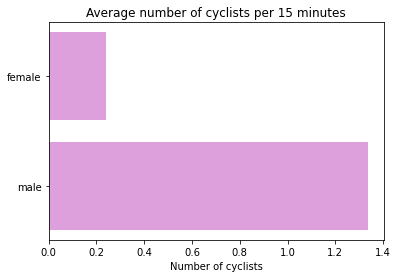

In [10]:
# Male vs female cyclists (Outer London)
sex_df = pd.DataFrame(london[['male', 'female']].mean(), columns=['mean']).reset_index()
plt.barh(sex_df['index'], sex_df['mean'], color = 'plum')
plt.title('Average number of cyclists per 15 minutes')
plt.xlabel('Number of cyclists')

Text(0.5, 0, 'Number of cyclists')

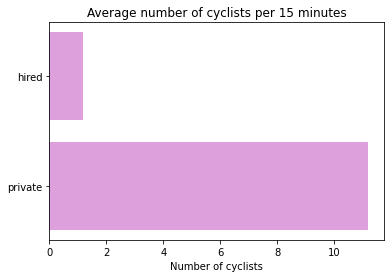

In [11]:
# Private vs hired cycles (Inner and Central London)
private_df = pd.DataFrame(london[['private', 'hired']].mean(), columns=['mean']).reset_index()
plt.barh(private_df['index'], private_df['mean'], color = 'plum')
plt.title('Average number of cyclists per 15 minutes')
plt.xlabel('Number of cyclists')

### Infrastructure data 

In [12]:
# Get borough of each London site 
sites = pd.read_excel('London/Biking sites.xlsx')[[
    'UnqID', 'Borough']].rename(columns={'UnqID':'site', 'Borough':'borough'})
london = london.merge(sites, how='left', on='site')

# Group london data by borough
london_boroughs = london.groupby(['borough']).mean()[['total_cycles']].reset_index()

In [13]:
# Get borough infrastructure data 
borough_df = pd.read_csv('london_infrastructure/borough_infrastructure.csv')

In [14]:
# Merge borough data together
borough_df = pd.merge(london_boroughs, borough_df, how='outer', on='borough')

# Correlations between mean cyclists and surveyed infrastructure 
for col in ['cycle_parking_count', 'restricted_point_count', 'signage_count', 'signal_count', 'traffic_calming_count', 
            'crossing_count', 'advanced_stop_line_count', 'restricted_route_count', 'cycle_lane_track_count']:
    print(col, '\n', np.corrcoef(borough_df['total_cycles'], borough_df[col]), '\n')

cycle_parking_count 
 [[1.         0.58849277]
 [0.58849277 1.        ]] 

restricted_point_count 
 [[ 1.         -0.13278599]
 [-0.13278599  1.        ]] 

signage_count 
 [[1.        0.0227193]
 [0.0227193 1.       ]] 

signal_count 
 [[1.         0.75412353]
 [0.75412353 1.        ]] 

traffic_calming_count 
 [[ 1.         -0.00523325]
 [-0.00523325  1.        ]] 

crossing_count 
 [[ 1.         -0.44456452]
 [-0.44456452  1.        ]] 

advanced_stop_line_count 
 [[1.         0.62821962]
 [0.62821962 1.        ]] 

restricted_route_count 
 [[1.         0.19811602]
 [0.19811602 1.        ]] 

cycle_lane_track_count 
 [[ 1.         -0.46381071]
 [-0.46381071  1.        ]] 



### Modelling 

In [15]:
# Load distance to infrastructure data 
updated_sites = pd.read_csv('London/updated_sites.csv')

In [16]:
# Add infrastructure data to dataframe 

distance_data = updated_sites[['UnqID', 'closest_restricted_point', 'restricted_point_count_100m',
 'restricted_point_count_1000m', 'closest_signal', 'signal_count_100m', 'signal_count_1000m',
 'closest_crossing', 'crossing_count_100m', 'crossing_count_1000m', 'closest_advanced_stop_line',
 'advanced_stop_line_count_100m', 'advanced_stop_line_count_1000m', 'closest_restricted_route',
 'restricted_route_count_100m', 'restricted_route_count_1000m', 'closest_cycle_parking',
 'cycle_parking_count_100m', 'cycle_parking_count_1000m']].rename(columns={'UnqID':'site'})

london = london.merge(distance_data, how='left', on='site')

In [17]:
# Select features for model 
london_model = london[['year', 'month', 'day_of_week', 'period', 'hour', 'area', 'borough', 'weather', 
                       'total_cycles', 'closest_restricted_point', 'restricted_point_count_100m', 
                       'restricted_point_count_1000m', 'closest_signal', 'signal_count_100m', 
                       'signal_count_1000m', 'closest_crossing', 'crossing_count_100m', 
                       'crossing_count_1000m', 'closest_advanced_stop_line', 'advanced_stop_line_count_100m', 
                       'advanced_stop_line_count_1000m', 'closest_restricted_route', 
                       'restricted_route_count_100m', 'restricted_route_count_1000m', 'closest_cycle_parking', 
                       'cycle_parking_count_100m', 'cycle_parking_count_1000m']]

# Exclude rows with null values 
london_model = london_model.dropna()

# ~1.6% of total rows dropped
(london_model.shape[0]/london.shape[0])*100

98.41891796508082

In [18]:
# Change month column from float to int
london_model.month = london_model.month.astype(int)

# Set categorical categories as category 
cat_cols = ['month', 'day_of_week', 'period', 'area', 'borough', 'weather']
for col in cat_cols:
    london_model[col] = london_model[col].astype('category')
    london_model[col] = london_model[col].cat.codes

# Record categorical columns 
cat_index = []
for col in cat_cols:
    cat_index.append(london_model.columns.get_loc(col))

In [19]:
# CatBoost model 
X = london_model.drop(['total_cycles'], axis=1)
y = london_model.total_cycles

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.25, random_state=13)

train_dataset = cb.Pool(X_train, y_train, cat_features=cat_index) 
eval_dataset = cb.Pool(X_eval, y_eval, cat_features=cat_index)
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_index)

In [20]:
model = cb.CatBoostRegressor(loss_function='Poisson', 
                             learning_rate=0.1, 
                             depth=10, 
                             iterations=2000)

model.fit(train_dataset, eval_set=eval_dataset, 
          early_stopping_rounds=100, use_best_model=True, verbose=True)

0:	learn: -1.5848899	test: -1.5842957	best: -1.5842957 (0)	total: 1.67s	remaining: 55m 30s
1:	learn: -3.8536743	test: -3.8537403	best: -3.8537403 (1)	total: 2.94s	remaining: 49m 1s
2:	learn: -5.9271959	test: -5.9267463	best: -5.9267463 (2)	total: 4.36s	remaining: 48m 24s
3:	learn: -7.7070273	test: -7.7055966	best: -7.7055966 (3)	total: 5.66s	remaining: 47m 2s
4:	learn: -9.2646497	test: -9.2631164	best: -9.2631164 (4)	total: 7.04s	remaining: 46m 48s
5:	learn: -10.6846824	test: -10.6822848	best: -10.6822848 (5)	total: 8.36s	remaining: 46m 18s
6:	learn: -11.8958411	test: -11.8934435	best: -11.8934435 (6)	total: 9.65s	remaining: 45m 48s
7:	learn: -12.9432422	test: -12.9401769	best: -12.9401769 (7)	total: 11s	remaining: 45m 36s
8:	learn: -13.8336246	test: -13.8312375	best: -13.8312375 (8)	total: 12.1s	remaining: 44m 34s
9:	learn: -14.6016967	test: -14.5984002	best: -14.5984002 (9)	total: 13.4s	remaining: 44m 27s
10:	learn: -15.2758095	test: -15.2709914	best: -15.2709914 (10)	total: 14.6s	re

86:	learn: -20.4116952	test: -20.3799838	best: -20.3799838 (86)	total: 1m 45s	remaining: 38m 33s
87:	learn: -20.4291686	test: -20.3973992	best: -20.3973992 (87)	total: 1m 46s	remaining: 38m 29s
88:	learn: -20.4324044	test: -20.3998444	best: -20.3998444 (88)	total: 1m 47s	remaining: 38m 24s
89:	learn: -20.4364470	test: -20.4035138	best: -20.4035138 (89)	total: 1m 48s	remaining: 38m 19s
90:	learn: -20.4482667	test: -20.4153865	best: -20.4153865 (90)	total: 1m 49s	remaining: 38m 14s
91:	learn: -20.4522690	test: -20.4189681	best: -20.4189681 (91)	total: 1m 50s	remaining: 38m 10s
92:	learn: -20.4619110	test: -20.4282610	best: -20.4282610 (92)	total: 1m 51s	remaining: 38m 4s
93:	learn: -20.4655812	test: -20.4317805	best: -20.4317805 (93)	total: 1m 52s	remaining: 37m 58s
94:	learn: -20.4686487	test: -20.4347496	best: -20.4347496 (94)	total: 1m 53s	remaining: 37m 51s
95:	learn: -20.4771449	test: -20.4430944	best: -20.4430944 (95)	total: 1m 54s	remaining: 37m 47s
96:	learn: -20.4836073	test: -2

170:	learn: -20.8624478	test: -20.8082378	best: -20.8082378 (170)	total: 3m 15s	remaining: 34m 52s
171:	learn: -20.8639264	test: -20.8093205	best: -20.8093205 (171)	total: 3m 16s	remaining: 34m 49s
172:	learn: -20.8651360	test: -20.8101857	best: -20.8101857 (172)	total: 3m 17s	remaining: 34m 47s
173:	learn: -20.8658567	test: -20.8106494	best: -20.8106494 (173)	total: 3m 18s	remaining: 34m 44s
174:	learn: -20.8699962	test: -20.8145117	best: -20.8145117 (174)	total: 3m 19s	remaining: 34m 44s
175:	learn: -20.8707316	test: -20.8147277	best: -20.8147277 (175)	total: 3m 20s	remaining: 34m 43s
176:	learn: -20.8722591	test: -20.8162052	best: -20.8162052 (176)	total: 3m 22s	remaining: 34m 41s
177:	learn: -20.8736216	test: -20.8167836	best: -20.8167836 (177)	total: 3m 23s	remaining: 34m 39s
178:	learn: -20.8754312	test: -20.8184229	best: -20.8184229 (178)	total: 3m 24s	remaining: 34m 38s
179:	learn: -20.8787814	test: -20.8214731	best: -20.8214731 (179)	total: 3m 25s	remaining: 34m 39s
180:	learn

254:	learn: -21.0047926	test: -20.9273929	best: -20.9273929 (254)	total: 4m 49s	remaining: 33m
255:	learn: -21.0050923	test: -20.9275046	best: -20.9275046 (255)	total: 4m 50s	remaining: 32m 58s
256:	learn: -21.0082163	test: -20.9304614	best: -20.9304614 (256)	total: 4m 51s	remaining: 32m 57s
257:	learn: -21.0087869	test: -20.9309201	best: -20.9309201 (257)	total: 4m 52s	remaining: 32m 55s
258:	learn: -21.0097611	test: -20.9316339	best: -20.9316339 (258)	total: 4m 53s	remaining: 32m 53s
259:	learn: -21.0109478	test: -20.9322419	best: -20.9322419 (259)	total: 4m 54s	remaining: 32m 51s
260:	learn: -21.0110461	test: -20.9322834	best: -20.9322834 (260)	total: 4m 55s	remaining: 32m 50s
261:	learn: -21.0125101	test: -20.9335013	best: -20.9335013 (261)	total: 4m 56s	remaining: 32m 49s
262:	learn: -21.0131990	test: -20.9337790	best: -20.9337790 (262)	total: 4m 57s	remaining: 32m 47s
263:	learn: -21.0136278	test: -20.9339628	best: -20.9339628 (263)	total: 4m 59s	remaining: 32m 47s
264:	learn: -2

338:	learn: -21.0812167	test: -20.9824288	best: -20.9824288 (338)	total: 6m 24s	remaining: 31m 21s
339:	learn: -21.0817802	test: -20.9828837	best: -20.9828837 (339)	total: 6m 25s	remaining: 31m 20s
340:	learn: -21.0828959	test: -20.9833055	best: -20.9833055 (340)	total: 6m 26s	remaining: 31m 19s
341:	learn: -21.0834458	test: -20.9833862	best: -20.9833862 (341)	total: 6m 27s	remaining: 31m 18s
342:	learn: -21.0838911	test: -20.9836912	best: -20.9836912 (342)	total: 6m 28s	remaining: 31m 17s
343:	learn: -21.0853353	test: -20.9850272	best: -20.9850272 (343)	total: 6m 29s	remaining: 31m 16s
344:	learn: -21.0861265	test: -20.9851459	best: -20.9851459 (344)	total: 6m 31s	remaining: 31m 16s
345:	learn: -21.0867187	test: -20.9854741	best: -20.9854741 (345)	total: 6m 32s	remaining: 31m 14s
346:	learn: -21.0867893	test: -20.9854683	best: -20.9854741 (345)	total: 6m 33s	remaining: 31m 13s
347:	learn: -21.0874429	test: -20.9854685	best: -20.9854741 (345)	total: 6m 34s	remaining: 31m 11s
348:	learn

422:	learn: -21.1289944	test: -21.0051966	best: -21.0051966 (422)	total: 7m 55s	remaining: 29m 33s
423:	learn: -21.1296892	test: -21.0057194	best: -21.0057194 (423)	total: 7m 57s	remaining: 29m 33s
424:	learn: -21.1306259	test: -21.0064365	best: -21.0064365 (424)	total: 7m 58s	remaining: 29m 32s
425:	learn: -21.1309505	test: -21.0063940	best: -21.0064365 (424)	total: 7m 59s	remaining: 29m 31s
426:	learn: -21.1317047	test: -21.0069467	best: -21.0069467 (426)	total: 8m	remaining: 29m 30s
427:	learn: -21.1324683	test: -21.0071788	best: -21.0071788 (427)	total: 8m 1s	remaining: 29m 29s
428:	learn: -21.1327272	test: -21.0073278	best: -21.0073278 (428)	total: 8m 2s	remaining: 29m 28s
429:	learn: -21.1335667	test: -21.0078574	best: -21.0078574 (429)	total: 8m 3s	remaining: 29m 27s
430:	learn: -21.1337673	test: -21.0078684	best: -21.0078684 (430)	total: 8m 5s	remaining: 29m 26s
431:	learn: -21.1344421	test: -21.0076495	best: -21.0078684 (430)	total: 8m 6s	remaining: 29m 25s
432:	learn: -21.134

506:	learn: -21.1690098	test: -21.0208368	best: -21.0208858 (505)	total: 9m 34s	remaining: 28m 10s
507:	learn: -21.1693974	test: -21.0210747	best: -21.0210747 (507)	total: 9m 35s	remaining: 28m 9s
508:	learn: -21.1702627	test: -21.0218494	best: -21.0218494 (508)	total: 9m 36s	remaining: 28m 7s
509:	learn: -21.1703460	test: -21.0219338	best: -21.0219338 (509)	total: 9m 37s	remaining: 28m 6s
510:	learn: -21.1710850	test: -21.0222897	best: -21.0222897 (510)	total: 9m 38s	remaining: 28m 4s
511:	learn: -21.1713091	test: -21.0223681	best: -21.0223681 (511)	total: 9m 39s	remaining: 28m 3s
512:	learn: -21.1715833	test: -21.0223318	best: -21.0223681 (511)	total: 9m 40s	remaining: 28m 2s
513:	learn: -21.1719065	test: -21.0224287	best: -21.0224287 (513)	total: 9m 41s	remaining: 28m 1s
514:	learn: -21.1720267	test: -21.0224567	best: -21.0224567 (514)	total: 9m 42s	remaining: 28m
515:	learn: -21.1721977	test: -21.0224706	best: -21.0224706 (515)	total: 9m 43s	remaining: 27m 59s
516:	learn: -21.17260

589:	learn: -21.1983323	test: -21.0329244	best: -21.0329918 (588)	total: 11m 4s	remaining: 26m 27s
590:	learn: -21.1989788	test: -21.0334203	best: -21.0334203 (590)	total: 11m 5s	remaining: 26m 26s
591:	learn: -21.1990981	test: -21.0334327	best: -21.0334327 (591)	total: 11m 6s	remaining: 26m 25s
592:	learn: -21.1992950	test: -21.0335255	best: -21.0335255 (592)	total: 11m 7s	remaining: 26m 24s
593:	learn: -21.1996170	test: -21.0335939	best: -21.0335939 (593)	total: 11m 8s	remaining: 26m 23s
594:	learn: -21.1999563	test: -21.0335825	best: -21.0335939 (593)	total: 11m 10s	remaining: 26m 22s
595:	learn: -21.2002269	test: -21.0338411	best: -21.0338411 (595)	total: 11m 11s	remaining: 26m 21s
596:	learn: -21.2006328	test: -21.0339484	best: -21.0339484 (596)	total: 11m 12s	remaining: 26m 20s
597:	learn: -21.2009282	test: -21.0338195	best: -21.0339484 (596)	total: 11m 13s	remaining: 26m 19s
598:	learn: -21.2011559	test: -21.0338642	best: -21.0339484 (596)	total: 11m 14s	remaining: 26m 18s
599:	

672:	learn: -21.2257267	test: -21.0330016	best: -21.0345061 (612)	total: 12m 37s	remaining: 24m 53s
673:	learn: -21.2258535	test: -21.0330048	best: -21.0345061 (612)	total: 12m 38s	remaining: 24m 52s
674:	learn: -21.2267970	test: -21.0338788	best: -21.0345061 (612)	total: 12m 39s	remaining: 24m 51s
675:	learn: -21.2270305	test: -21.0336864	best: -21.0345061 (612)	total: 12m 40s	remaining: 24m 50s
676:	learn: -21.2272189	test: -21.0338037	best: -21.0345061 (612)	total: 12m 41s	remaining: 24m 48s
677:	learn: -21.2276993	test: -21.0340757	best: -21.0345061 (612)	total: 12m 42s	remaining: 24m 47s
678:	learn: -21.2278650	test: -21.0341073	best: -21.0345061 (612)	total: 12m 43s	remaining: 24m 46s
679:	learn: -21.2280083	test: -21.0339173	best: -21.0345061 (612)	total: 12m 45s	remaining: 24m 45s
680:	learn: -21.2282990	test: -21.0339125	best: -21.0345061 (612)	total: 12m 45s	remaining: 24m 43s
681:	learn: -21.2286146	test: -21.0338001	best: -21.0345061 (612)	total: 12m 47s	remaining: 24m 42s


In [23]:
# Model performance 
from sklearn import metrics

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
mae = round(metrics.mean_absolute_error(y_test, pred), 2)

r_squared = r2_score(y_test, pred)
print(f'RMSE: {rmse}')
print(f'R Squared: {r_squared}')
print(f'Mean Absolute Error: {mae}')
print(rmse - mae)

RMSE: 12.67055815710229
R Squared: 0.6516024119067684
Mean Absolute Error: 5.26
7.41055815710229


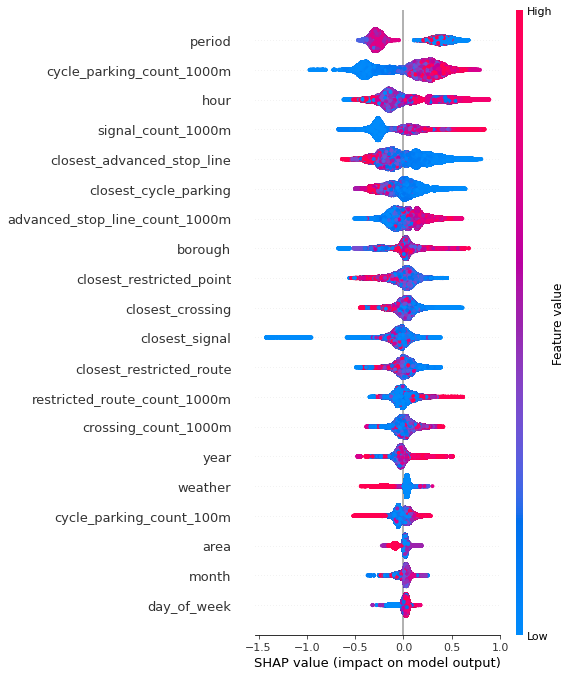

In [24]:
# Feature importance with infrastructure data 
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [25]:
# CatBoost model 
X = london_model.drop(['total_cycles'], axis=1)
y = london_model.total_cycles

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.25, random_state=13)

train_dataset = cb.Pool(X_train, y_train, cat_features=cat_index) 
eval_dataset = cb.Pool(X_eval, y_eval, cat_features=cat_index)
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_index)

model = cb.CatBoostRegressor(loss_function='Poisson', 
                             learning_rate=0.1, 
                             depth=10, 
                             iterations=10000)

model.fit(train_dataset, eval_set=eval_dataset, 
          early_stopping_rounds=100, use_best_model=True, verbose=True)

0:	learn: -1.5848899	test: -1.5842957	best: -1.5842957 (0)	total: 1.06s	remaining: 2h 56m 9s
1:	learn: -3.8536743	test: -3.8537403	best: -3.8537403 (1)	total: 2.11s	remaining: 2h 55m 40s
2:	learn: -5.9271959	test: -5.9267463	best: -5.9267463 (2)	total: 3.19s	remaining: 2h 57m 26s
3:	learn: -7.7070273	test: -7.7055966	best: -7.7055966 (3)	total: 4.4s	remaining: 3h 3m 20s
4:	learn: -9.2646497	test: -9.2631164	best: -9.2631164 (4)	total: 5.46s	remaining: 3h 1m 55s
5:	learn: -10.6846824	test: -10.6822848	best: -10.6822848 (5)	total: 6.5s	remaining: 3h 35s
6:	learn: -11.8958411	test: -11.8934435	best: -11.8934435 (6)	total: 7.56s	remaining: 2h 59m 47s
7:	learn: -12.9432422	test: -12.9401769	best: -12.9401769 (7)	total: 8.63s	remaining: 2h 59m 37s
8:	learn: -13.8336246	test: -13.8312375	best: -13.8312375 (8)	total: 9.58s	remaining: 2h 57m 15s
9:	learn: -14.6016967	test: -14.5984002	best: -14.5984002 (9)	total: 10.7s	remaining: 2h 58m 9s
10:	learn: -15.2758095	test: -15.2709914	best: -15.2709

84:	learn: -20.3984754	test: -20.3673927	best: -20.3673927 (84)	total: 1m 30s	remaining: 2h 56m
85:	learn: -20.4028650	test: -20.3714318	best: -20.3714318 (85)	total: 1m 31s	remaining: 2h 56m 4s
86:	learn: -20.4116952	test: -20.3799838	best: -20.3799838 (86)	total: 1m 32s	remaining: 2h 56m 8s
87:	learn: -20.4291686	test: -20.3973992	best: -20.3973992 (87)	total: 1m 33s	remaining: 2h 56m 14s
88:	learn: -20.4324044	test: -20.3998444	best: -20.3998444 (88)	total: 1m 34s	remaining: 2h 56m 8s
89:	learn: -20.4364470	test: -20.4035138	best: -20.4035138 (89)	total: 1m 36s	remaining: 2h 56m 18s
90:	learn: -20.4482667	test: -20.4153865	best: -20.4153865 (90)	total: 1m 37s	remaining: 2h 56m 5s
91:	learn: -20.4522690	test: -20.4189681	best: -20.4189681 (91)	total: 1m 38s	remaining: 2h 56m 10s
92:	learn: -20.4619110	test: -20.4282610	best: -20.4282610 (92)	total: 1m 39s	remaining: 2h 56m 4s
93:	learn: -20.4655812	test: -20.4317805	best: -20.4317805 (93)	total: 1m 40s	remaining: 2h 55m 56s
94:	learn

166:	learn: -20.8472756	test: -20.7936846	best: -20.7936846 (166)	total: 2m 57s	remaining: 2h 53m 52s
167:	learn: -20.8482117	test: -20.7939782	best: -20.7939782 (167)	total: 2m 58s	remaining: 2h 53m 52s
168:	learn: -20.8526646	test: -20.7984025	best: -20.7984025 (168)	total: 2m 59s	remaining: 2h 53m 48s
169:	learn: -20.8599671	test: -20.8057527	best: -20.8057527 (169)	total: 3m	remaining: 2h 53m 46s
170:	learn: -20.8624478	test: -20.8082378	best: -20.8082378 (170)	total: 3m 1s	remaining: 2h 53m 44s
171:	learn: -20.8639264	test: -20.8093205	best: -20.8093205 (171)	total: 3m 2s	remaining: 2h 53m 36s
172:	learn: -20.8651360	test: -20.8101857	best: -20.8101857 (172)	total: 3m 3s	remaining: 2h 53m 30s
173:	learn: -20.8658567	test: -20.8106494	best: -20.8106494 (173)	total: 3m 4s	remaining: 2h 53m 25s
174:	learn: -20.8699962	test: -20.8145117	best: -20.8145117 (174)	total: 3m 5s	remaining: 2h 53m 20s
175:	learn: -20.8707316	test: -20.8147277	best: -20.8147277 (175)	total: 3m 6s	remaining: 2

247:	learn: -20.9984664	test: -20.9231551	best: -20.9231551 (247)	total: 4m 22s	remaining: 2h 52m 3s
248:	learn: -20.9987368	test: -20.9231763	best: -20.9231763 (248)	total: 4m 23s	remaining: 2h 51m 58s
249:	learn: -21.0010717	test: -20.9253111	best: -20.9253111 (249)	total: 4m 24s	remaining: 2h 51m 57s
250:	learn: -21.0020302	test: -20.9256464	best: -20.9256464 (250)	total: 4m 25s	remaining: 2h 51m 53s
251:	learn: -21.0031368	test: -20.9265942	best: -20.9265942 (251)	total: 4m 26s	remaining: 2h 51m 52s
252:	learn: -21.0037021	test: -20.9268463	best: -20.9268463 (252)	total: 4m 27s	remaining: 2h 51m 52s
253:	learn: -21.0039290	test: -20.9269352	best: -20.9269352 (253)	total: 4m 28s	remaining: 2h 51m 45s
254:	learn: -21.0047926	test: -20.9273929	best: -20.9273929 (254)	total: 4m 29s	remaining: 2h 51m 44s
255:	learn: -21.0050923	test: -20.9275046	best: -20.9275046 (255)	total: 4m 30s	remaining: 2h 51m 40s
256:	learn: -21.0082163	test: -20.9304614	best: -20.9304614 (256)	total: 4m 31s	rem

328:	learn: -21.0703138	test: -20.9741884	best: -20.9741884 (328)	total: 5m 56s	remaining: 2h 54m 49s
329:	learn: -21.0730849	test: -20.9770084	best: -20.9770084 (329)	total: 5m 58s	remaining: 2h 54m 53s
330:	learn: -21.0734555	test: -20.9771507	best: -20.9771507 (330)	total: 5m 59s	remaining: 2h 54m 54s
331:	learn: -21.0738669	test: -20.9772805	best: -20.9772805 (331)	total: 6m	remaining: 2h 55m
332:	learn: -21.0747153	test: -20.9778957	best: -20.9778957 (332)	total: 6m 1s	remaining: 2h 55m 3s
333:	learn: -21.0752937	test: -20.9780764	best: -20.9780764 (333)	total: 6m 2s	remaining: 2h 55m 3s
334:	learn: -21.0764984	test: -20.9786002	best: -20.9786002 (334)	total: 6m 3s	remaining: 2h 55m 1s
335:	learn: -21.0784631	test: -20.9806679	best: -20.9806679 (335)	total: 6m 5s	remaining: 2h 55m 2s
336:	learn: -21.0789121	test: -20.9808340	best: -20.9808340 (336)	total: 6m 6s	remaining: 2h 55m 4s
337:	learn: -21.0797410	test: -20.9813174	best: -20.9813174 (337)	total: 6m 7s	remaining: 2h 55m 7s


409:	learn: -21.1225571	test: -21.0034811	best: -21.0034906 (408)	total: 7m 28s	remaining: 2h 54m 51s
410:	learn: -21.1233767	test: -21.0038507	best: -21.0038507 (410)	total: 7m 29s	remaining: 2h 54m 50s
411:	learn: -21.1236924	test: -21.0038395	best: -21.0038507 (410)	total: 7m 30s	remaining: 2h 54m 50s
412:	learn: -21.1239914	test: -21.0036643	best: -21.0038507 (410)	total: 7m 31s	remaining: 2h 54m 51s
413:	learn: -21.1245074	test: -21.0036829	best: -21.0038507 (410)	total: 7m 33s	remaining: 2h 54m 53s
414:	learn: -21.1252682	test: -21.0040373	best: -21.0040373 (414)	total: 7m 34s	remaining: 2h 54m 53s
415:	learn: -21.1259158	test: -21.0043236	best: -21.0043236 (415)	total: 7m 35s	remaining: 2h 54m 57s
416:	learn: -21.1263608	test: -21.0043230	best: -21.0043236 (415)	total: 7m 36s	remaining: 2h 54m 59s
417:	learn: -21.1266290	test: -21.0043705	best: -21.0043705 (417)	total: 7m 37s	remaining: 2h 54m 56s
418:	learn: -21.1273569	test: -21.0045191	best: -21.0045191 (418)	total: 7m 39s	re

490:	learn: -21.1618802	test: -21.0179821	best: -21.0179821 (490)	total: 8m 56s	remaining: 2h 53m 16s
491:	learn: -21.1620908	test: -21.0181063	best: -21.0181063 (491)	total: 8m 57s	remaining: 2h 53m 14s
492:	learn: -21.1623472	test: -21.0182122	best: -21.0182122 (492)	total: 8m 58s	remaining: 2h 53m 12s
493:	learn: -21.1623852	test: -21.0182141	best: -21.0182141 (493)	total: 9m	remaining: 2h 53m 11s
494:	learn: -21.1628919	test: -21.0183713	best: -21.0183713 (494)	total: 9m 1s	remaining: 2h 53m 10s
495:	learn: -21.1636699	test: -21.0184015	best: -21.0184015 (495)	total: 9m 2s	remaining: 2h 53m 8s
496:	learn: -21.1644722	test: -21.0191858	best: -21.0191858 (496)	total: 9m 3s	remaining: 2h 53m 6s
497:	learn: -21.1653067	test: -21.0193767	best: -21.0193767 (497)	total: 9m 4s	remaining: 2h 53m 4s
498:	learn: -21.1659897	test: -21.0195924	best: -21.0195924 (498)	total: 9m 5s	remaining: 2h 53m 4s
499:	learn: -21.1660747	test: -21.0195978	best: -21.0195978 (499)	total: 9m 6s	remaining: 2h 53

571:	learn: -21.1921665	test: -21.0301728	best: -21.0301788 (570)	total: 10m 25s	remaining: 2h 51m 56s
572:	learn: -21.1923363	test: -21.0301476	best: -21.0301788 (570)	total: 10m 27s	remaining: 2h 51m 58s
573:	learn: -21.1926353	test: -21.0302212	best: -21.0302212 (573)	total: 10m 28s	remaining: 2h 51m 59s
574:	learn: -21.1929450	test: -21.0304066	best: -21.0304066 (574)	total: 10m 29s	remaining: 2h 51m 59s
575:	learn: -21.1935064	test: -21.0306460	best: -21.0306460 (575)	total: 10m 30s	remaining: 2h 51m 56s
576:	learn: -21.1942425	test: -21.0312889	best: -21.0312889 (576)	total: 10m 31s	remaining: 2h 51m 52s
577:	learn: -21.1948770	test: -21.0317755	best: -21.0317755 (577)	total: 10m 32s	remaining: 2h 51m 49s
578:	learn: -21.1950340	test: -21.0318523	best: -21.0318523 (578)	total: 10m 33s	remaining: 2h 51m 48s
579:	learn: -21.1951251	test: -21.0318551	best: -21.0318551 (579)	total: 10m 34s	remaining: 2h 51m 47s
580:	learn: -21.1953908	test: -21.0318463	best: -21.0318551 (579)	total: 

651:	learn: -21.2205077	test: -21.0341761	best: -21.0345061 (612)	total: 11m 55s	remaining: 2h 50m 51s
652:	learn: -21.2206360	test: -21.0342177	best: -21.0345061 (612)	total: 11m 56s	remaining: 2h 50m 51s
653:	learn: -21.2207820	test: -21.0342404	best: -21.0345061 (612)	total: 11m 57s	remaining: 2h 50m 53s
654:	learn: -21.2208927	test: -21.0342468	best: -21.0345061 (612)	total: 11m 58s	remaining: 2h 50m 54s
655:	learn: -21.2213804	test: -21.0343642	best: -21.0345061 (612)	total: 11m 59s	remaining: 2h 50m 51s
656:	learn: -21.2216601	test: -21.0341950	best: -21.0345061 (612)	total: 12m	remaining: 2h 50m 51s
657:	learn: -21.2221109	test: -21.0339747	best: -21.0345061 (612)	total: 12m 2s	remaining: 2h 50m 51s
658:	learn: -21.2222386	test: -21.0338312	best: -21.0345061 (612)	total: 12m 3s	remaining: 2h 50m 50s
659:	learn: -21.2224559	test: -21.0338637	best: -21.0345061 (612)	total: 12m 4s	remaining: 2h 50m 55s
660:	learn: -21.2228264	test: -21.0338015	best: -21.0345061 (612)	total: 12m 5s	

In [26]:
# Model performance 
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r_squared = r2_score(y_test, pred)
print(f'RMSE: {rmse}')
print(f'R Squared: {r_squared}')
print(f'Mean Absolute Error: {mae}')
print(rmse - mae)

RMSE: 12.67055815710229
R Squared: 0.6516024119067684
Mean Absolute Error: 5.26
7.41055815710229


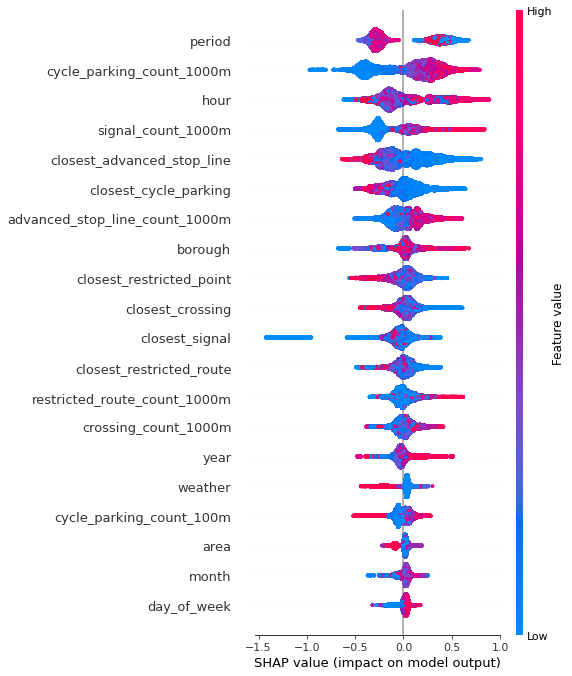

In [27]:
# Feature importance with infrastructure data 
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

# Regression Tree

Regression trees work on continuous data and try to predict a numeric value based on a set of independent features.

In [28]:
# import some more libraries
import statsmodels.api as sm
import math

import seaborn as sns
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

In [29]:
# Create the decision tree regressor class and for the object to the data set
regressor = DecisionTreeRegressor(random_state = 0)

regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [30]:
# Evaluate the model prediction by predicting the response for the test data
y_pred = regressor.predict(X_test)

# Specify the MAE and MSE and RMSE
mae = round(metrics.mean_absolute_error(y_test, y_pred), 2)
mse = round(metrics.mean_squared_error(y_test, y_pred), 2)
rmse = round(math.sqrt(metrics.mean_squared_error(y_test, y_pred)),2)

print('Mean Absolute Error: ', mae)
print('Mean squared Error: ', rmse)
print('Root Mean Squared Error', rmse)

print(round(rmse-mae,2))

Mean Absolute Error:  5.65
Mean squared Error:  14.37
Root Mean Squared Error 14.37
8.72


The difference between RMSE and MAE determines how well the regression tree has performed. The closer to 0 the better the fit on the dataset. With a value of 8.72, the value is fairly low. 

To determine the feature importance, an evaluation is performed on the independent variables

Feature: 0, Score: 0.05122
Feature: 1, Score: 0.03794
Feature: 2, Score: 0.02996
Feature: 3, Score: 0.13305
Feature: 4, Score: 0.09527
Feature: 5, Score: 0.00042
Feature: 6, Score: 0.01058
Feature: 7, Score: 0.01023
Feature: 8, Score: 0.07307
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00407
Feature: 11, Score: 0.13171
Feature: 12, Score: 0.00594
Feature: 13, Score: 0.14074
Feature: 14, Score: 0.01691
Feature: 15, Score: 0.00103
Feature: 16, Score: 0.02086
Feature: 17, Score: 0.06756
Feature: 18, Score: 0.00500
Feature: 19, Score: 0.04160
Feature: 20, Score: 0.01900
Feature: 21, Score: 0.00081
Feature: 22, Score: 0.01888
Feature: 23, Score: 0.03735
Feature: 24, Score: 0.01101
Feature: 25, Score: 0.03577


<AxesSubplot:xlabel='Importance', ylabel='Variable'>

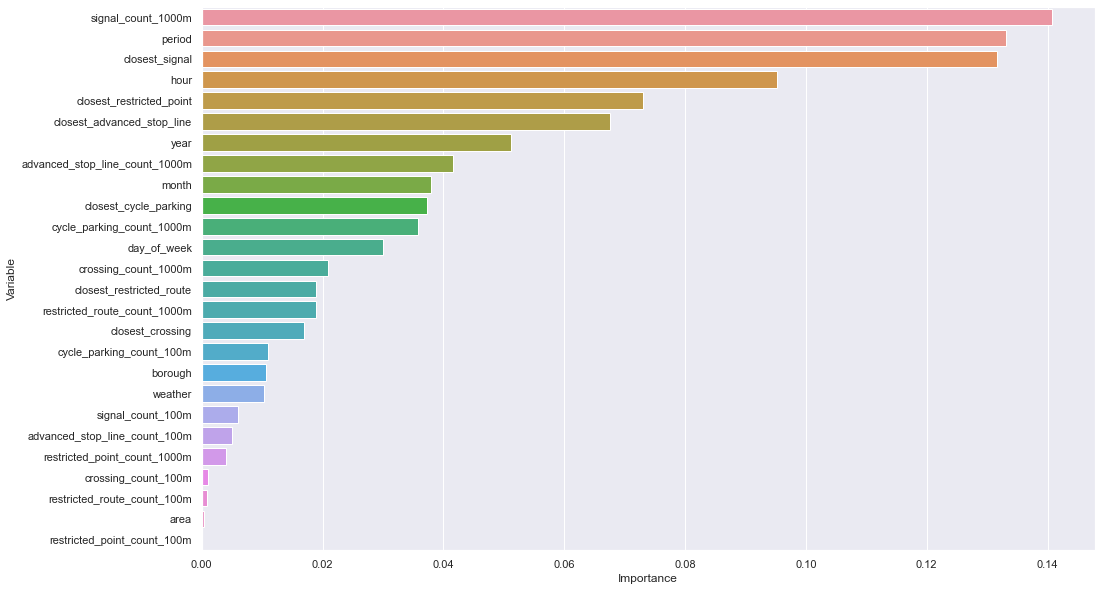

In [31]:
# get importance
importance = regressor.feature_importances_

# Summarize the feature importance
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# bring the Features into a df and visualize the feature importances
reg_tree_importance = pd.DataFrame({'Variable': X.columns,
                                    'Importance': importance})\
                                    .sort_values('Importance', ascending = False)

sns.set(rc={'figure.figsize':(16,10)})
sns.barplot(data = reg_tree_importance, x = 'Importance', y = 'Variable')

<AxesSubplot:xlabel='total_cycles', ylabel='Density'>

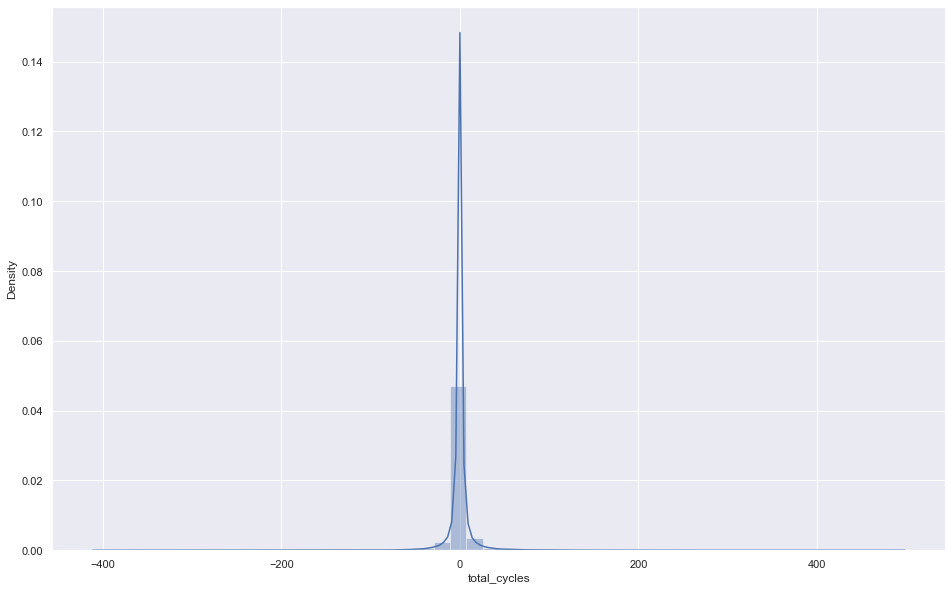

In [32]:
# Show the difference between labeled and predicted y values
import warnings
warnings.filterwarnings("ignore") 

sns.distplot(y_test-y_pred)

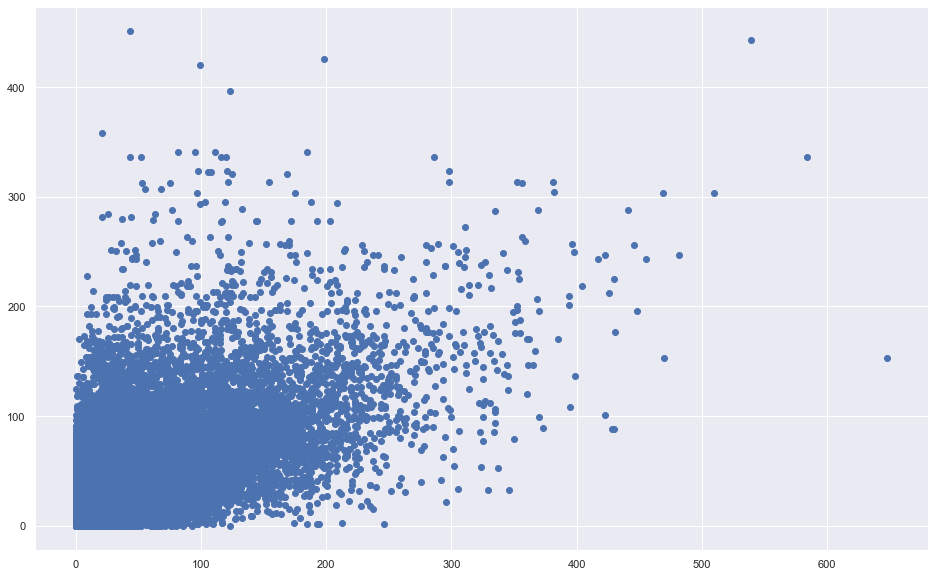

In [33]:
# Checking the predicted values using a scatter plot
plt.scatter(y_test,y_pred)

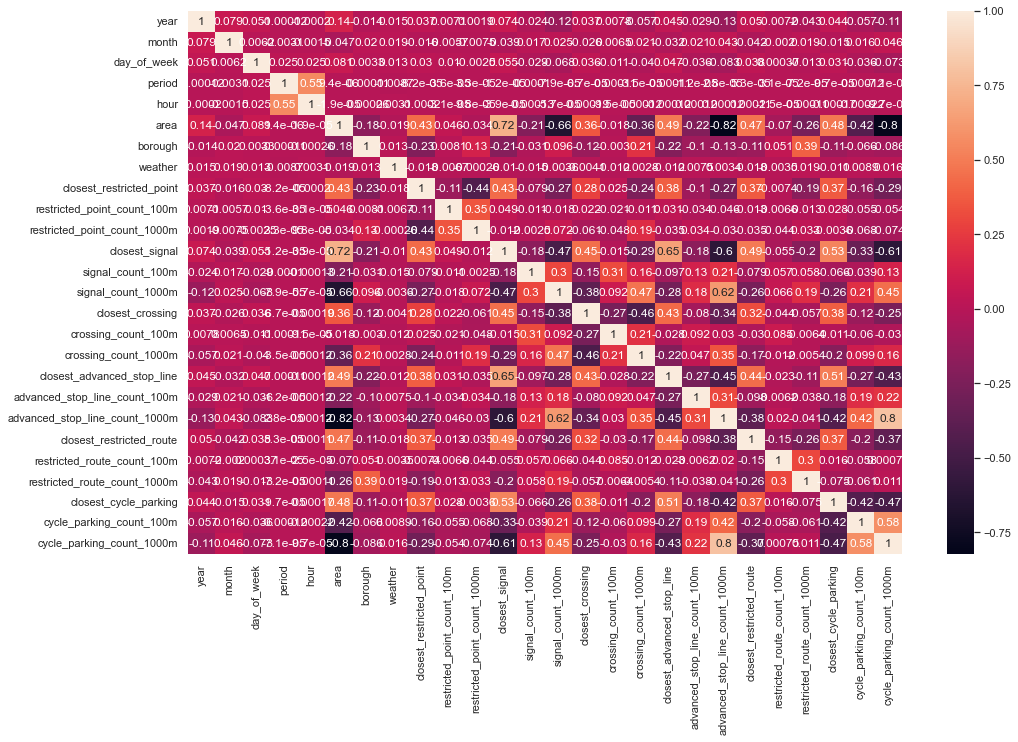

In [34]:
# Check for multicollinearity in the model
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot = True)
plt.show()

At first glance the notable correlation is betwen cycle parking counts and advanced stop line counts in km range. Closest signal and area also seem to be highly correlated. 

**Next Steps**

* Determine features to drop that are not as important to the model
* Create a Random forest to use against the model
* Create a ridge regression after feature selection

## Random forest

Next a random forest algorithm is used to compare the output of the decision tree. 
It generally performs better than a single regression tree. 

In [36]:
# Import the random forest classifier
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
random_forest = RandomForestRegressor()

# Run the regression tree with
forest = RandomForestRegressor(n_estimators = 1400, max_features = 'sqrt', bootstrap = False,
                               n_jobs = -1, max_depth = 100, min_samples_leaf = 1, min_samples_split = 5
                               )

forest.fit(X_train, y_train)
forest_predict = forest.predict(X_test)

# Print the evaluation
mae_forest = round(metrics.mean_absolute_error(y_test, forest_predict), 2)
mse_forest = round(metrics.mean_squared_error(y_test, forest_predict), 2)
rmse_forest = round(math.sqrt(metrics.mean_squared_error(y_test, forest_predict)), 2)

print(round(mae_forest,2))
print(round(mse_forest,2))
print(round(rmse_forest,2))

print(round(rmse_forest-mae_forest,2))

5.63
204.32
14.29
8.66


## Interpretation

The difference between the RMSE and MAE is 8.66 using the random forest regression model, this performs slightly better than the single regression tree but not better than the catboost model. The feature importances are evaluated next. 

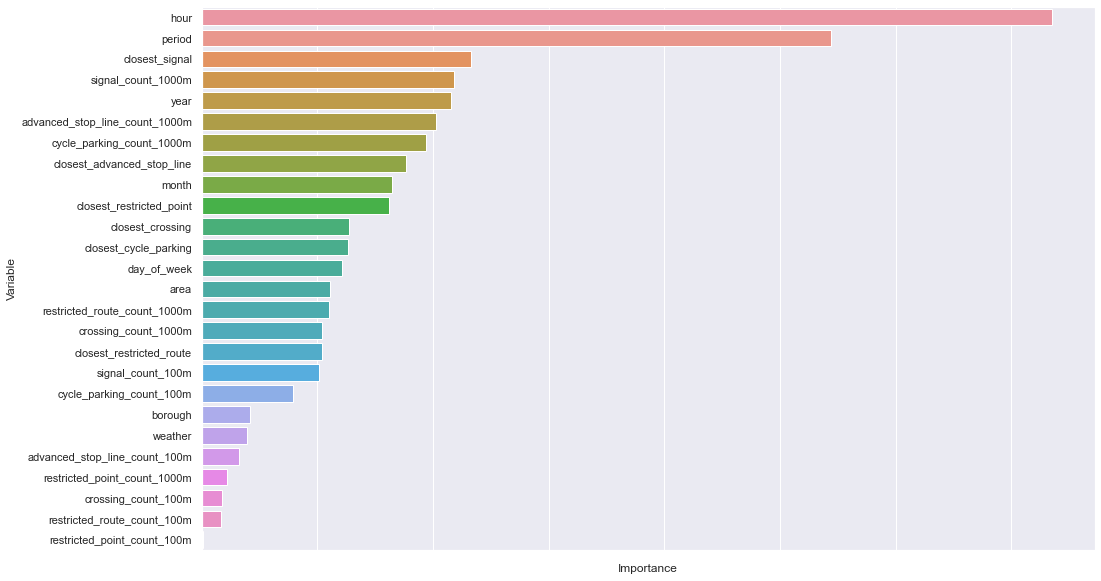

In [37]:
# Create a DF to store the importances of the variables
forest_df = pd.DataFrame({'Variable': X.columns,
                         'Importance': forest.feature_importances_})\
                         .sort_values('Importance', ascending = False)


# Visualize the importances with a bachart
sns.set(rc={'figure.figsize':(16,10)})

viz = sns.barplot(data = forest_df,
                  x = 'Importance',
                  y = 'Variable')

viz.set_xticklabels(viz.get_xticklabels(), rotation = 40, ha = 'right')
plt.show()